# Tabnet Hyperoptimization

In [1]:
import pandas as pd
from load_data import *
from matplotlib import pyplot as plt
%matplotlib inline
import tabnet
import tensorflow as tf
import keras_tuner as kt
import matplotlib.pyplot as plt
import os
import seaborn as sns 
%matplotlib inline
from sklearn.model_selection import KFold

In [2]:
def R_squared(y, y_pred):
  residual = tf.reduce_sum(tf.square(tf.subtract(y, y_pred)))
  total = tf.reduce_sum(tf.square(tf.subtract(y, tf.reduce_mean(y))))
  r2 = tf.subtract(1.0, tf.math.divide(residual, total))
  
  return r2

In [3]:
def transform(ds):
    features = tf.unstack(ds["features"])
    prices = ds["price"]

    x = dict(zip(col_names, features))
    y = prices
    return x, y

## Selected Variables

### Output and Feature Dimension
Output and Feature dimension have a large impact on performance, so do the optimization only concerning them

In [4]:
X_train, X_test, X_val, y_train, y_test, y_val = load_data(for_dendro = False)

------------------------------
Fit and Transform data...
------------------------------
58 amenities have been removed due to close zero-variance.
Text, OpenStreet and image data loaded.
44 binary variables have been removed due to close zero-variance.
Imputation done. No NaN's are left in the data.
PCA's built and correlated features dropped.
Due to insignificant t-tests we drop:
['host_is_superhost', 'Extra pillows and blankets', 'Luggage dropoff allowed', 'Free_parking', 'host_name_sounds_west', 'host_name_sounds_rare', 'neighbourhood_cleansed_Dn Laoghaire-Rathdown']
------------------------------
Transform data...
------------------------------
58 amenities have been removed due to close zero-variance.
Text, OpenStreet and image data loaded.
44 binary variables have been removed due to close zero-variance.
Imputation done. No NaN's are left in the data.
PCA's built and correlated features dropped.
Due to insignificant t-tests we drop:
['host_is_superhost', 'Extra pillows and blanke

In [5]:
X_train = pd.concat([X_train, X_val])
y_train = pd.concat([y_train, y_val])

In [6]:
bin_col = [col for col in X_train if np.isin(X_train[col].unique(), [0, 1]).all()]
num_col = [col for col in X_train if ~np.isin(X_train[col].unique(), [0, 1]).all()]
col_names = bin_col + num_col

What I want to Grid search for

In [7]:
ods = [30, 40, 50, 60, 70, 80, 90, 100, 110, 120] 
fds = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
overview_mae = pd.DataFrame(np.zeros((len(ods), len(fds))))
overview_mse = pd.DataFrame(np.zeros((len(ods), len(fds))))
overview_r2 = pd.DataFrame(np.zeros((len(ods), len(fds))))
overview_mae.columns = fds
overview_mae.index = ods
overview_mse.columns = fds
overview_mse.index = ods
overview_r2.columns = fds
overview_r2.index = ods

In [8]:
for i in ods:
    for j in fds:
        
        mae_min = []
        mse_min = []
        r2_max = []

        kf = KFold(n_splits=5, shuffle=True, random_state=1234)
        for train_index, test_index in kf.split(X_train):
            print("TRAIN:", train_index, "TEST:", test_index)
            X_train_kf, X_val_kf = X_train.iloc[train_index, :], X_train.iloc[test_index, :]
            y_train_kf, y_val_kf = y_train.iloc[train_index], y_train.iloc[test_index]

            train_size = int(X_train_kf.shape[0] * 0.9)
            batch_size = int(X_train_kf.shape[0] * 0.1)

            data_train = tf.data.Dataset.from_tensor_slices({"features": X_train_kf, "price": y_train_kf})
            data_train = data_train.shuffle(6000, seed = 13)
            train_dataset = data_train.take(len(X_train_kf))
            train_dataset = train_dataset.map(transform)
            train_dataset = train_dataset.batch(batch_size)

            data_test = tf.data.Dataset.from_tensor_slices({"features": X_val_kf, "price": y_val_kf})
            test_dataset = data_test.take(len(X_val_kf))
            test_dataset = test_dataset.map(transform)
            test_dataset = test_dataset.batch(batch_size)

            feature_columns = []

            for col in col_names:
                feature_columns.append(tf.feature_column.numeric_column(col))

            model = tabnet.TabNetRegression(feature_columns, num_regressors=1,
                                            output_dim=i, feature_dim=i+j, num_groups=1,
                                            num_decision_steps=2)
                                            
            lr = 0.01
            optimizer = tf.keras.optimizers.Adam(lr)
            model.compile(optimizer, loss=['mse', "mae"] , metrics=[R_squared, "mse", "mae"])

            hist_model = model.fit(train_dataset, epochs=50, 
                                validation_data=test_dataset, verbose=1)

            mae_min.append(np.min(hist_model.history["val_mae"]))
            mse_min.append(np.min(hist_model.history["val_mse"]))
            r2_max.append(np.max(hist_model.history["val_R_squared"]))


        mae_min_m = np.mean(mae_min)
        mse_min_m = np.mean(mse_min)
        r2_max_m = np.mean(r2_max)

        overview_mae.at[i, j] = mae_min_m
        overview_mse.at[i, j] = mse_min_m
        overview_r2.at[i, j] = r2_max_m

TRAIN: [   1    2    3 ... 5309 5310 5311] TEST: [   0    8   14 ... 5301 5302 5306]
[TabNet]: 1 features will be used for decision steps.
Epoch 1/50

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

11/11 [==============================] - 2s 225ms/step - loss: 6.7287 - R_squared: -13.3807 - mse: 6.7287 - mae: 2.0818 - val_loss: 1.1313 - val_R_squared: -1.4261 - val_mse: 1.1313 - val_mae: 0.8951
Epoch 2/50
11/11 [==============================] - 1s 74ms/step - loss: 0.6599 - R_squared: -0.5383 - mse: 0.6599 - mae: 0.6578 - val_loss: 0.4706 - val_R_sq

In [ ]:
fds_ind = ["+1", "+2", "+3", "+4", "+5", "+6", "+7", "+8", "+9", "+10"] # for a better labeling of the resulting heatmap
overview_mae.columns = fds_ind
overview_mse.columns = fds_ind
overview_r2.columns = fds_ind

In [12]:
overview_mae = pd.read_csv("TabNet_GS/GS_mae_selected.csv")
overview_mse = pd.read_csv("TabNet_GS/GS_mse_selected.csv")
overview_r2 = pd.read_csv("TabNet_GS/GS_R2_selected.csv")
ods = [30, 40, 50, 60, 70, 80, 90, 100, 110, 120] 
overview_mae.index = ods
overview_mse.index = ods
overview_r2.index = ods
del overview_mae["Unnamed: 0"]
del overview_mse["Unnamed: 0"]
del overview_r2["Unnamed: 0"]

C:\Users\49173\anaconda3\envs\DL_tabnet\lib\site-packages\ipykernel_launcher.py:5: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "drpi" which is no longer supported as of 3.3 and will become an error in 3.6
  """


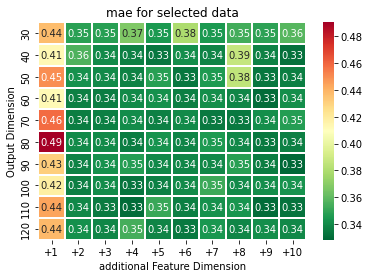

In [13]:
sns.heatmap(overview_mae, cmap ='RdYlGn_r', linewidths = 0.30, annot = True)
plt.title("mae for selected data")
plt.xlabel("additional Feature Dimension")
plt.ylabel("Output Dimension")
plt.savefig("TabNet_selected_GS_mae", drpi = 300)

C:\Users\49173\anaconda3\envs\DL_tabnet\lib\site-packages\ipykernel_launcher.py:5: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "drpi" which is no longer supported as of 3.3 and will become an error in 3.6
  """


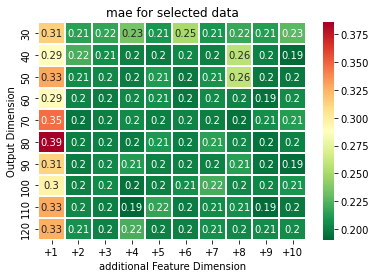

In [14]:
sns.heatmap(overview_mse, cmap ='RdYlGn_r', linewidths = 0.30, annot = True)
plt.title("mae for selected data")
plt.xlabel("additional Feature Dimension")
plt.ylabel("Output Dimension")
plt.savefig("TabNet_selected_GS_mse", drpi = 300)

C:\Users\49173\anaconda3\envs\DL_tabnet\lib\site-packages\ipykernel_launcher.py:5: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "drpi" which is no longer supported as of 3.3 and will become an error in 3.6
  """


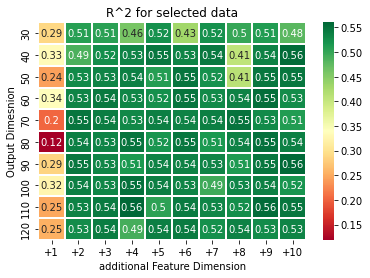

In [15]:
sns.heatmap(overview_r2, cmap ='RdYlGn', linewidths = 0.30, annot = True)
plt.title("R^2 for selected data")
plt.xlabel("additional Feature Dimension")
plt.ylabel("Output Dimension")
plt.savefig("TabNet_selected_GridSearch_r2", drpi = 300)

In [16]:
np.max(overview_r2.values)

0.560219943523407

In [17]:
overview_r2.loc[110,"+4"]

0.560219943523407

In [ ]:
#overview_mae.to_csv("GS_mae_selected.csv")
#overview_mse.to_csv("GS_mse_selected.csv")
#overview_r2.to_csv("GS_R2_selected.csv")

Choose output_dim = 110 und feature_dim = 114 as best model.
Now steps and relaxation factor.

In [9]:
od = 110
fd = 114
nds = [2, 3, 4, 5, 6, 7, 8, 9, 10]
rf = [1, 1.5, 2, 2.5, 3, 3.5]

In [11]:
overview_mae_2 = pd.DataFrame(np.zeros((len(nds), len(rf))))
overview_mse_2 = pd.DataFrame(np.zeros((len(nds), len(rf))))
overview_r2_2 = pd.DataFrame(np.zeros((len(nds), len(rf))))
overview_mae_2.columns = rf
overview_mae_2.index = nds
overview_mse_2.columns = rf
overview_mse_2.index = nds
overview_r2_2.columns = rf
overview_r2_2.index = nds

In [ ]:
for i in nds:
    for j in rf:
        
        mae_min = []
        mse_min = []
        r2_max = []

        kf = KFold(n_splits=5, shuffle=True, random_state=1234)
        for train_index, test_index in kf.split(X_train):
            print("TRAIN:", train_index, "TEST:", test_index)
            X_train_kf, X_val_kf = X_train.iloc[train_index, :], X_train.iloc[test_index, :]
            y_train_kf, y_val_kf = y_train.iloc[train_index], y_train.iloc[test_index]

            train_size = int(X_train_kf.shape[0] * 0.9)
            batch_size = int(X_train_kf.shape[0] * 0.1)

            data_train = tf.data.Dataset.from_tensor_slices({"features": X_train_kf, "price": y_train_kf})
             data_train = data_train.shuffle(6000, seed = 13)
            train_dataset = data_train.take(len(X_train_kf))
            train_dataset = train_dataset.map(transform)
            train_dataset = train_dataset.batch(batch_size)

            data_test = tf.data.Dataset.from_tensor_slices({"features": X_val_kf, "price": y_val_kf})
            test_dataset = data_test.take(len(X_val_kf))
            test_dataset = test_dataset.map(transform)
            test_dataset = test_dataset.batch(batch_size)

            feature_columns = []

            for col in col_names:
                feature_columns.append(tf.feature_column.numeric_column(col))

            model = tabnet.TabNetRegression(feature_columns, num_regressors=1,
                                            output_dim=od, feature_dim=fd, num_groups=1,
                                            num_decision_steps=i, relaxation_factor=j)
                                            
            lr = 0.01
            optimizer = tf.keras.optimizers.Adam(lr)
            model.compile(optimizer, loss=['mse', "mae"] , metrics=[R_squared, "mse", "mae"])

            hist_model = model.fit(train_dataset, epochs=50,
                                validation_data=test_dataset, verbose=1)

            mae_min.append(np.min(hist_model.history["val_mae"]))
            mse_min.append(np.min(hist_model.history["val_mse"]))
            r2_max.append(np.max(hist_model.history["val_R_squared"]))


        mae_min_m = np.mean(mae_min)
        mse_min_m = np.mean(mse_min)
        r2_max_m = np.mean(r2_max)

        overview_mae_2.at[i, j] = mae_min_m
        overview_mse_2.at[i, j] = mse_min_m
        overview_r2_2.at[i, j] = r2_max_m

In [9]:
overview_mae_2 = pd.read_csv("TabNet_GS/GS_mae_nds_rf_selected.csv")
overview_mse_2 = pd.read_csv("TabNet_GS/GS_mse_nds_rf_selected.csv")
overview_r2_2 = pd.read_csv("TabNet_GS/GS_R2_nds_rf_selected.csv")
del overview_mae_2["Unnamed: 0"]
del overview_mse_2["Unnamed: 0"]
del overview_r2_2["Unnamed: 0"]
nds = [2, 3, 4, 5, 6, 7, 8, 9, 10]
rf = [1, 1.5, 2, 2.5, 3, 3.5]
overview_mae_2.columns = rf
overview_mae_2.index = nds
overview_mse_2.columns = rf
overview_mse_2.index = nds
overview_r2_2.columns = rf
overview_r2_2.index = nds

C:\Users\49173\anaconda3\envs\DL_tabnet\lib\site-packages\ipykernel_launcher.py:5: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "drpi" which is no longer supported as of 3.3 and will become an error in 3.6
  """


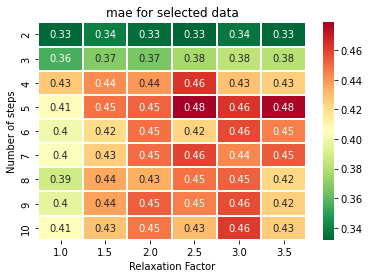

In [13]:
sns.heatmap(overview_mae_2, cmap ='RdYlGn_r', linewidths = 0.30, annot = True)
plt.title("mae for selected data")
plt.xlabel("Relaxation Factor")
plt.ylabel("Number of steps")
plt.savefig("TabNet_selected_GS_mae_2_NEW", drpi = 300)

C:\Users\49173\anaconda3\envs\DL_tabnet\lib\site-packages\ipykernel_launcher.py:5: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "drpi" which is no longer supported as of 3.3 and will become an error in 3.6
  """


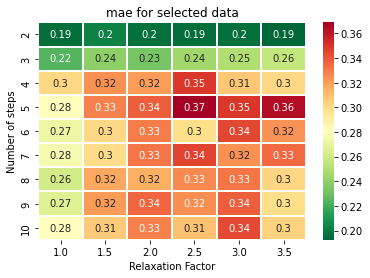

In [14]:
sns.heatmap(overview_mse_2, cmap ='RdYlGn_r', linewidths = 0.30, annot = True)
plt.title("mae for selected data")
plt.xlabel("Relaxation Factor")
plt.ylabel("Number of steps")
plt.savefig("TabNet_selected_GS_mse_2_NEW", drpi = 300)

C:\Users\49173\anaconda3\envs\DL_tabnet\lib\site-packages\ipykernel_launcher.py:5: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "drpi" which is no longer supported as of 3.3 and will become an error in 3.6
  """


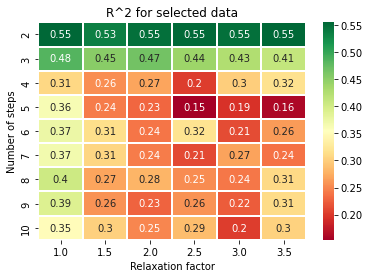

In [16]:
sns.heatmap(overview_r2_2, cmap ='RdYlGn', linewidths = 0.30, annot = True)
plt.title("R^2 for selected data")
plt.xlabel("Relaxation factor")
plt.ylabel("Number of steps")
plt.savefig("TabNet_selected_GS_r2_2_NEW", drpi = 300)

In [23]:
overview_mae_2.loc[2,2.5]

0.3318178117275238

In [25]:
overview_r2_2.loc[2,2.5]

0.5526307702064515

In [18]:
#overview_mae_2.to_csv("GS_mae_nds_rf_selected.csv")
#overview_mse_2.to_csv("GS_mse_nds_rf_selected.csv")
#overview_r2_2.to_csv("GS_R2_nds_rf_selected.csv")

In [31]:
od = 110
fd = 114
nds = 2
rf = 2.5
sc = [ 1e-2, 1e-3, 1e-4, 1e-5]
overview_mae_3 = pd.DataFrame(np.zeros((1, len(sc))))
overview_mse_3 = pd.DataFrame(np.zeros((1, len(sc))))
overview_r2_3 = pd.DataFrame(np.zeros((1, len(sc))))
overview_mae_3.columns = sc
overview_mse_3.columns = sc
overview_r2_3.columns = sc

In [32]:
for j in sc:
        
    mae_min = []
    mse_min = []
    r2_max = []

    kf = KFold(n_splits=5, shuffle=True, random_state=1234)
    for train_index, test_index in kf.split(X_train):
        print("TRAIN:", train_index, "TEST:", test_index)
        X_train_kf, X_val_kf = X_train.iloc[train_index, :], X_train.iloc[test_index, :]
        y_train_kf, y_val_kf = y_train.iloc[train_index], y_train.iloc[test_index]

        train_size = int(X_train_kf.shape[0] * 0.9)
        batch_size = int(X_train_kf.shape[0] * 0.1)

        data_train = tf.data.Dataset.from_tensor_slices({"features": X_train_kf, "price": y_train_kf})
        data_train = data_train.shuffle(6000, seed = 13)
        train_dataset = data_train.take(len(X_train_kf))
        train_dataset = train_dataset.map(transform)
        train_dataset = train_dataset.batch(batch_size)

        data_test = tf.data.Dataset.from_tensor_slices({"features": X_val_kf, "price": y_val_kf})
        test_dataset = data_test.take(len(X_val_kf))
        test_dataset = test_dataset.map(transform)
        test_dataset = test_dataset.batch(batch_size)

        feature_columns = []

        for col in col_names:
            feature_columns.append(tf.feature_column.numeric_column(col))

        model = tabnet.TabNetRegression(feature_columns, num_regressors=1,
                                            output_dim=od, feature_dim=fd, num_groups=1,
                                            num_decision_steps=nds, relaxation_factor=rf,
                                            sparsity_coefficient=j)
                                            
        lr = 0.01
        optimizer = tf.keras.optimizers.Adam(lr)
        model.compile(optimizer, loss=['mse', "mae"] , metrics=[R_squared, "mse", "mae"])

        hist_model = model.fit(train_dataset, epochs=50,
                                validation_data=test_dataset, verbose=1)

        mae_min.append(np.min(hist_model.history["val_mae"]))
        mse_min.append(np.min(hist_model.history["val_mse"]))
        r2_max.append(np.max(hist_model.history["val_R_squared"]))


    mae_min_m = np.mean(mae_min)
    mse_min_m = np.mean(mse_min)
    r2_max_m = np.mean(r2_max)

    overview_mae_3.at[0, j] = mae_min_m
    overview_mse_3.at[0, j] = mse_min_m
    overview_r2_3.at[0, j] = r2_max_m

TRAIN: [   1    2    3 ... 5309 5310 5311] TEST: [   0    8   14 ... 5301 5302 5306]
[TabNet]: 4 features will be used for decision steps.
Epoch 1/50

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

11/11 [==============================] - 2s 203ms/step - loss: 3.7133 - R_squared: -6.7467 - mse: 3.7133 - mae: 1.3157 - val_loss: 0.6720 - val_R_squared: -0.4446 - val_mse: 0.6720 - val_mae: 0.6682
Epoch 2/50
11/11 [==============================] - 1s 78ms/step - loss: 0.4695 - R_squared: -0.0962 - mse: 0.4695 - mae: 0.5465 - val_loss: 0.4937 - val_R_squ

C:\Users\49173\anaconda3\envs\DL_tabnet\lib\site-packages\ipykernel_launcher.py:5: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "drpi" which is no longer supported as of 3.3 and will become an error in 3.6
  """


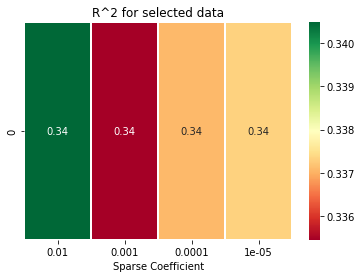

In [36]:
sns.heatmap(overview_mae_3, cmap ='RdYlGn', linewidths = 0.30, annot = True)
plt.title("R^2 for selected data")
plt.xlabel("Sparse Coefficient")
plt.ylabel("")
plt.savefig("TabNet_selected_GS_mae_3", drpi = 300)

C:\Users\49173\anaconda3\envs\DL_tabnet\lib\site-packages\ipykernel_launcher.py:5: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "drpi" which is no longer supported as of 3.3 and will become an error in 3.6
  """


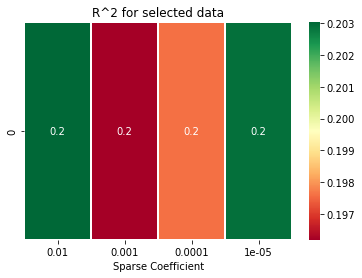

In [37]:
sns.heatmap(overview_mse_3, cmap ='RdYlGn', linewidths = 0.30, annot = True)
plt.title("R^2 for selected data")
plt.xlabel("Sparse Coefficient")
plt.ylabel("")
plt.savefig("TabNet_selected_GS_mse_3", drpi = 300)

C:\Users\49173\anaconda3\envs\DL_tabnet\lib\site-packages\ipykernel_launcher.py:5: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "drpi" which is no longer supported as of 3.3 and will become an error in 3.6
  """


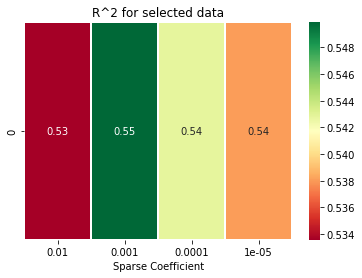

In [38]:
sns.heatmap(overview_r2_3, cmap ='RdYlGn', linewidths = 0.30, annot = True)
plt.title("R^2 for selected data")
plt.xlabel("Sparse Coefficient")
plt.ylabel("")
plt.savefig("TabNet_selected_GS_r2_3", drpi = 300)

In [39]:
overview_mae_3.to_csv("GS_mae_sc_selected.csv")
overview_mse_3.to_csv("GS_mse_sc_selected.csv")
overview_r2_3.to_csv("GS_R2_sc_selected.csv")

# Final Model
od = 110
fd = 114
nds = 2
rf = 2.5
epo = 100
keep sc to default

In [40]:
od = 110
fd = 114
nds = 2
rf = 2.5
epo = 100

In [42]:
X_train, X_test, X_val, y_train, y_test, y_val = load_data(for_dendro = False)

------------------------------
Fit and Transform data...
------------------------------
58 amenities have been removed due to close zero-variance.
Text, OpenStreet and image data loaded.
44 binary variables have been removed due to close zero-variance.
Imputation done. No NaN's are left in the data.
PCA's built and correlated features dropped.
Due to insignificant t-tests we drop:
['host_is_superhost', 'Extra pillows and blankets', 'Luggage dropoff allowed', 'Free_parking', 'host_name_sounds_west', 'host_name_sounds_rare', 'neighbourhood_cleansed_Dn Laoghaire-Rathdown']
------------------------------
Transform data...
------------------------------
58 amenities have been removed due to close zero-variance.
Text, OpenStreet and image data loaded.
44 binary variables have been removed due to close zero-variance.
Imputation done. No NaN's are left in the data.
PCA's built and correlated features dropped.
Due to insignificant t-tests we drop:
['host_is_superhost', 'Extra pillows and blanke

In [43]:
bin_col = [col for col in X_train if np.isin(X_train[col].unique(), [0, 1]).all()]
num_col = [col for col in X_train if ~np.isin(X_train[col].unique(), [0, 1]).all()]
col_names = bin_col + num_col

In [44]:
train_size = int(X_train.shape[0] * 0.9)
batch_size = int(X_train.shape[0] * 0.1)

In [45]:
data_train = tf.data.Dataset.from_tensor_slices({"features": X_train, "price": y_train})
data_train = data_train.shuffle(6000, seed = 13)
train_dataset = data_train.take(len(X_train))
train_dataset = train_dataset.map(transform)
train_dataset = train_dataset.batch(batch_size)

data_test = tf.data.Dataset.from_tensor_slices({"features": X_val, "price": y_val})
test_dataset = data_test.take(len(X_val))
test_dataset = test_dataset.map(transform)
test_dataset = test_dataset.batch(batch_size)

In [46]:
feature_columns = []

for col in col_names:
    feature_columns.append(tf.feature_column.numeric_column(col))

In [48]:
lr = tf.keras.optimizers.schedules.ExponentialDecay(0.01, decay_steps=100, decay_rate=0.95, staircase=False)
#lr = 0.01
optimizer = tf.keras.optimizers.Adam(lr)

model1 = tabnet.TabNetRegression(feature_columns, num_regressors=1,
                                output_dim=od, feature_dim=fd, num_groups=1,
                                num_decision_steps=nds, relaxation_factor=rf)

checkpoint = tf.keras.callbacks.ModelCheckpoint(filepath="TabNet_GS/best_model1.hdf5",
                                                    monitor='val_R_squared',
                                                    verbose=1,
                                                    save_best_only=True,
                                                    save_weights_only=True,
                                                    mode='max')

model1.compile(optimizer, loss=['mse', "mae"] , metrics=[R_squared, "mse", "mae"])

hist_model1 = model1.fit(train_dataset, epochs=epo, 
                        validation_data=test_dataset, verbose=1,
                        callbacks=[checkpoint])

hist_df1 = pd.DataFrame(hist_model1.history)
hist_csv_file = 'history_TabNet_Selected1.csv'
with open(hist_csv_file, mode='w') as f:
    hist_df1.to_csv(f)

perf = np.max(hist_model1.history["val_R_squared"])

print("This Model had a maximum validation R-squared of: ", perf)

[TabNet]: 4 features will be used for decision steps.
Epoch 1/100

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

10/11 [==========================>...] - ETA: 0s - loss: 3.7976 - R_squared: -8.0227 - mse: 3.7976 - mae: 1.3234
Epoch 00001: val_R_squared improved from -inf to -0.34238, saving model to TabNet_GS\best_model1.hdf5
11/11 [==============================] - 3s 262ms/step - loss: 3.7934 - R_squared: -7.3041 - mse: 3.7934 - mae: 1.3224 - val_loss: 0.5794 - val_R_squared: -0.3424 - val_mse: 0.5794 - val_mae: 0.6021
Epoch 2/100
10/11 [=========

In [49]:
lr = tf.keras.optimizers.schedules.ExponentialDecay(0.01, decay_steps=100, decay_rate=0.95, staircase=False)
#lr = 0.01
optimizer = tf.keras.optimizers.Adam(lr)

model2 = tabnet.TabNetRegression(feature_columns, num_regressors=1,
                                output_dim=od, feature_dim=fd, num_groups=1,
                                num_decision_steps=nds, relaxation_factor=rf)

checkpoint = tf.keras.callbacks.ModelCheckpoint(filepath="TabNet_GS/best_model2.hdf5",
                                                    monitor='val_R_squared',
                                                    verbose=1,
                                                    save_best_only=True,
                                                    save_weights_only=True,
                                                    mode='max')

model2.compile(optimizer, loss=['mse', "mae"] , metrics=[R_squared, "mse", "mae"])

hist_model2 = model2.fit(train_dataset, epochs=epo, 
                        validation_data=test_dataset, verbose=1,
                        callbacks=[checkpoint])

hist_df2 = pd.DataFrame(hist_model2.history)
hist_csv_file = 'history_TabNet_Selected2.csv'
with open(hist_csv_file, mode='w') as f:
    hist_df2.to_csv(f)

perf = np.max(hist_model2.history["val_R_squared"])

print("This Model had a maximum validation R-squared of: ", perf)

[TabNet]: 4 features will be used for decision steps.
Epoch 1/100

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

10/11 [==========================>...] - ETA: 0s - loss: 3.5767 - R_squared: -7.4691 - mse: 3.5767 - mae: 1.3061
Epoch 00001: val_R_squared improved from -inf to -0.09273, saving model to TabNet_GS\best_model2.hdf5
11/11 [==============================] - 2s 218ms/step - loss: 3.5736 - R_squared: -6.9597 - mse: 3.5736 - mae: 1.3055 - val_loss: 0.4713 - val_R_squared: -0.0927 - val_mse: 0.4713 - val_mae: 0.5482
Epoch 2/100
10/11 [=========

In [50]:
lr = tf.keras.optimizers.schedules.ExponentialDecay(0.01, decay_steps=100, decay_rate=0.95, staircase=False)
#lr = 0.01
optimizer = tf.keras.optimizers.Adam(lr)

model3 = tabnet.TabNetRegression(feature_columns, num_regressors=1,
                                output_dim=od, feature_dim=fd, num_groups=1,
                                num_decision_steps=nds, relaxation_factor=rf)

checkpoint = tf.keras.callbacks.ModelCheckpoint(filepath="TabNet_GS/best_model3.hdf5",
                                                    monitor='val_R_squared',
                                                    verbose=1,
                                                    save_best_only=True,
                                                    save_weights_only=True,
                                                    mode='max')

model3.compile(optimizer, loss=['mse', "mae"] , metrics=[R_squared, "mse", "mae"])

hist_model3 = model3.fit(train_dataset, epochs=epo, 
                        validation_data=test_dataset, verbose=1,
                        callbacks=[checkpoint])

hist_df3 = pd.DataFrame(hist_model3.history)
hist_csv_file = 'history_TabNet_Selected3.csv'
with open(hist_csv_file, mode='w') as f:
    hist_df3.to_csv(f)

perf = np.max(hist_model3.history["val_R_squared"])

print("This Model had a maximum validation R-squared of: ", perf)

[TabNet]: 4 features will be used for decision steps.
Epoch 1/100

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

10/11 [==========================>...] - ETA: 0s - loss: 3.4339 - R_squared: -6.9946 - mse: 3.4339 - mae: 1.2745
Epoch 00001: val_R_squared improved from -inf to -0.30858, saving model to TabNet_GS\best_model3.hdf5
11/11 [==============================] - 5s 444ms/step - loss: 3.4299 - R_squared: -6.3048 - mse: 3.4299 - mae: 1.2734 - val_loss: 0.5089 - val_R_squared: -0.3086 - val_mse: 0.5089 - val_mae: 0.5665
Epoch 2/100
10/11 [=========

In [51]:
lr = tf.keras.optimizers.schedules.ExponentialDecay(0.01, decay_steps=100, decay_rate=0.95, staircase=False)
#lr = 0.01
optimizer = tf.keras.optimizers.Adam(lr)

model4 = tabnet.TabNetRegression(feature_columns, num_regressors=1,
                                output_dim=od, feature_dim=fd, num_groups=1,
                                num_decision_steps=nds, relaxation_factor=rf)

checkpoint = tf.keras.callbacks.ModelCheckpoint(filepath="TabNet_GS/best_model4.hdf5",
                                                    monitor='val_R_squared',
                                                    verbose=1,
                                                    save_best_only=True,
                                                    save_weights_only=True,
                                                    mode='max')

model4.compile(optimizer, loss=['mse', "mae"] , metrics=[R_squared, "mse", "mae"])

hist_model4 = model4.fit(train_dataset, epochs=epo, 
                        validation_data=test_dataset, verbose=1,
                        callbacks=[checkpoint])

hist_df4 = pd.DataFrame(hist_model4.history)
hist_csv_file = 'history_TabNet_Selected4.csv'
with open(hist_csv_file, mode='w') as f:
    hist_df4.to_csv(f)

perf = np.max(hist_model4.history["val_R_squared"])

print("This Model had a maximum validation R-squared of: ", perf)

[TabNet]: 4 features will be used for decision steps.
Epoch 1/100

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

10/11 [==========================>...] - ETA: 0s - loss: 3.2084 - R_squared: -6.4259 - mse: 3.2084 - mae: 1.2385
Epoch 00001: val_R_squared improved from -inf to -0.51987, saving model to TabNet_GS\best_model4.hdf5
11/11 [==============================] - 3s 300ms/step - loss: 3.2050 - R_squared: -5.8425 - mse: 3.2050 - mae: 1.2378 - val_loss: 0.6227 - val_R_squared: -0.5199 - val_mse: 0.6227 - val_mae: 0.6234
Epoch 2/100
10/11 [=========

In [52]:
lr = tf.keras.optimizers.schedules.ExponentialDecay(0.01, decay_steps=100, decay_rate=0.95, staircase=False)
#lr = 0.01
optimizer = tf.keras.optimizers.Adam(lr)

model5 = tabnet.TabNetRegression(feature_columns, num_regressors=1,
                                output_dim=od, feature_dim=fd, num_groups=1,
                                num_decision_steps=nds, relaxation_factor=rf)

checkpoint = tf.keras.callbacks.ModelCheckpoint(filepath="TabNet_GS/best_model5.hdf5",
                                                    monitor='val_R_squared',
                                                    verbose=1,
                                                    save_best_only=True,
                                                    save_weights_only=True,
                                                    mode='max')

model5.compile(optimizer, loss=['mse', "mae"] , metrics=[R_squared, "mse", "mae"])

hist_model5 = model5.fit(train_dataset, epochs=epo, 
                        validation_data=test_dataset, verbose=1,
                        callbacks=[checkpoint])

hist_df5 = pd.DataFrame(hist_model5.history)
hist_csv_file = 'history_TabNet_Selected5.csv'
with open(hist_csv_file, mode='w') as f:
    hist_df5.to_csv(f)

perf = np.max(hist_model5.history["val_R_squared"])

print("This Model had a maximum validation R-squared of: ", perf)

[TabNet]: 4 features will be used for decision steps.
Epoch 1/100

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

10/11 [==========================>...] - ETA: 0s - loss: 2.9716 - R_squared: -5.4481 - mse: 2.9716 - mae: 1.1977
Epoch 00001: val_R_squared improved from -inf to -0.19784, saving model to TabNet_GS\best_model5.hdf5
11/11 [==============================] - 5s 416ms/step - loss: 2.9685 - R_squared: -5.0262 - mse: 2.9685 - mae: 1.1970 - val_loss: 0.4674 - val_R_squared: -0.1978 - val_mse: 0.4674 - val_mae: 0.5539
Epoch 2/100
10/11 [=========

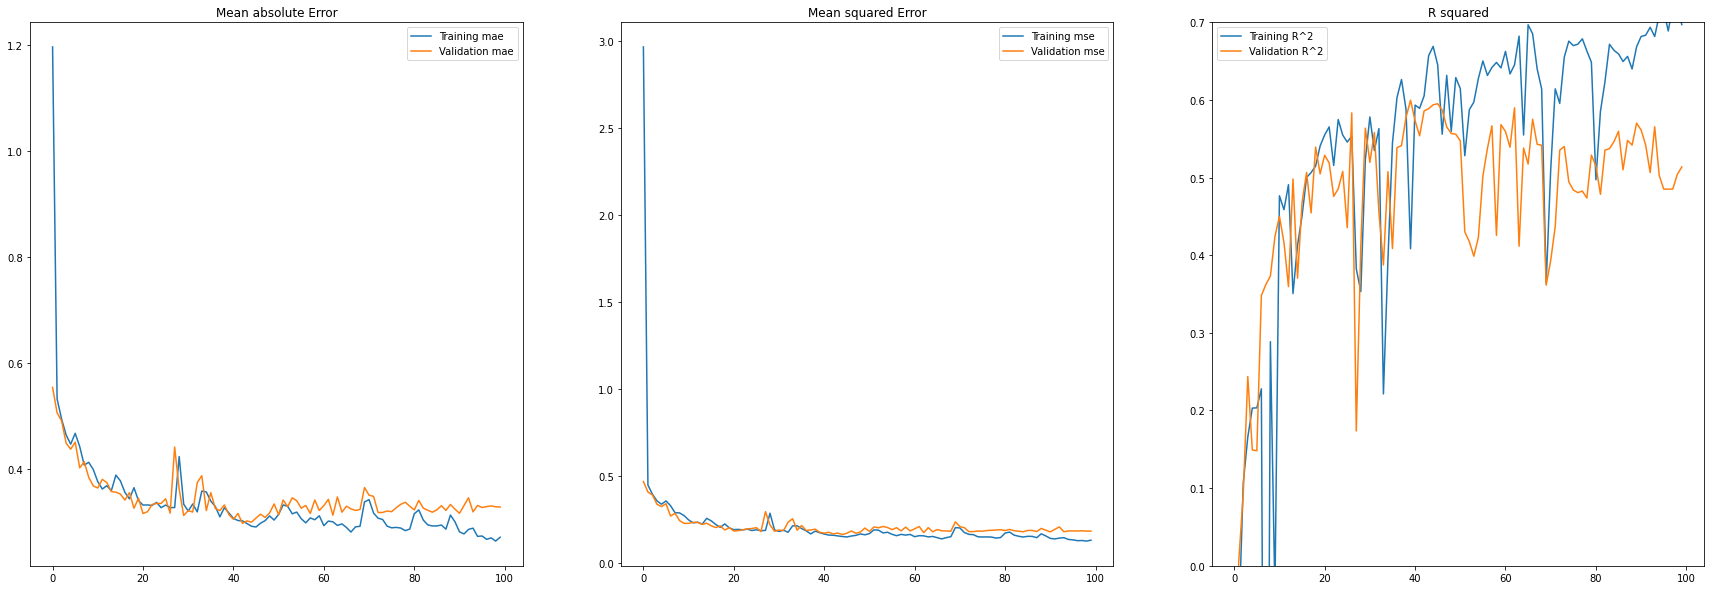

In [63]:
epochs_range = range(epo)
fig, axs = plt.subplots(1, 3, figsize=(30, 10))
axs[0].plot(epochs_range, hist_model5.history["mae"], label="Training mae")
axs[0].plot(epochs_range, hist_model5.history["val_mae"], label="Validation mae")
axs[0].set_title("Mean absolute Error")
axs[0].legend(loc='best')

axs[1].plot(epochs_range, hist_model5.history["mse"], label="Training mse")
axs[1].plot(epochs_range, hist_model5.history["val_mse"], label="Validation mse")
axs[1].set_title("Mean squared Error")
axs[1].legend(loc='best')

axs[2].plot(epochs_range, hist_model5.history["R_squared"], label="Training R^2")
axs[2].plot(epochs_range, hist_model5.history["val_R_squared"], label="Validation R^2")
axs[2].set_ylim((0, 0.7))
axs[2].set_title("R squared")
#axs[2].axhline(y = 0.6, color = "red")
axs[2].legend(loc='best')

plt.savefig("TabNet_GS/TabNet_Selected_Final.png")

0.4453851878643036